# Exercise set 7: Spatial data

In this exercise set you will be working with structuring and plotting spatial data. 
- Exercise 9.1: basic shapes
- Exercise 9.2: working with Geopandas and interpolation
- Exercise 9.3: interactive plotting with folium

We begin with loading the standard packages:


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely

import matplotlib.pyplot as plt

%matplotlib inline

## Exercises

### Part 9.1: Working with spatial objects 

This exercise will serve as a brief tutorial on spatial data. We will learn how to make spatial shape and use their basic operations.

> **Ex. 9.1.1** Make a polygon which is square that has left,lower corner in 2,2 and right,upper in 5,5. Make a triangle passing through (0,0), (4,0) and (2,4). What do they look like? Store the two polygons respectively as `square` and `triangle`

> *Hint*: the submodule shapely.geometry has methods such as `Point`, `Polygon` and `Multipolygon`

In [2]:
from shapely.geometry import Polygon

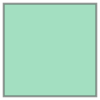

In [3]:
# [Your answer here]

square = Polygon([(2,2),(5,2),(5,5),(2,5)])

triangle = Polygon([(0,0),(4,0),(2,4)])

square

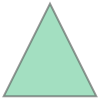

In [4]:
triangle

Surprisingly they look like a triangle and a square

> **Ex. 6.1.2** Compute and show the spatial difference of square subtracted triangle, also show the hat is the union of `square` and `triangle`?

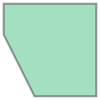

In [5]:
# [Your answer here]

square - triangle

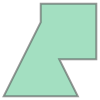

In [6]:
square | triangle

> **Ex. 6.1.3** Make a GeoSeries out of `square`, `triangle`. Plot the geoseries.

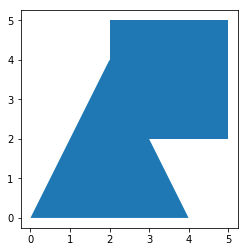

In [7]:
# [Your answer here]

series = gpd.GeoSeries([square, triangle])

series.plot()

### Part 9.2: Working with house sale prices

Data on danish municipalities are available [here](https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson) from Open Knowledge Denmark.

#### Basic operations with Geopandas

> **Ex. 9.2.1** Load the municipalities data using `gpd.read_file()`, 
- What is the CRS of the dataframe - what projection does it correspond to? Turn the CRS into a meter based system.
- Which three munipalities have the largest area?

> Note: to find the entire area of a municipality which consists of multiple shapes (e.g. municipalities covering islands). you can use the `unary_union` method for GeoSeries.

In [8]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"

In [9]:
# [Your answer here]

gdf = gpd.read_file(url)

print(gdf.crs) # corresponds to WGS 84

# CRS is EPSG 4326, uom is degrees. I change to EPSG:25832 as it's commonly used in Denmark 
# See https://sdfe.dk/saadan-arbejder-vi-med-data/geodaesi-og-referencenet/referencesystemer/ 
# and https://epsg.io/25832 uom is m

gdf = gdf.to_crs(epsg=25832)

# empty list for name and area
kom_name  = []
area = []

# unique values
kom_list = list(set(gdf['KOMNAVN']))

# calculate area for each municipality
for kom in kom_list:
    kom_name.append(kom)
    area.append(gdf.loc[gdf['KOMNAVN'] == kom]['geometry'].unary_union.area)

# create df for sorting and print three largest

df = pd.DataFrame({'kom':kom_name,'area':area})
df = df.sort_values(by=['area'])
print(df[-3:])


{'init': 'epsg:4326'}


C:\Users\Malini\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


                  kom          area
29            Herning  1.323127e+09
43             Viborg  1.419631e+09
25  Ringkøbing-Skjern  1.494151e+09


Use the script below to add regional information for municipalities. This code block assumes that your geodataframe is names `kommuner`.

In [10]:
kommuner = gdf

kommuner.columns = kommuner.columns.str.lower()
    
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

kommuner = kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')

> **Ex. 9.2.2** Make two boolean series as follows. 
> - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
> - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

> Finally make a combined series which takes the value True if both holds, otherwise False and use this series to create a new geodataframe containing only mainland Sealand. 


> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [11]:
# [Your answer here]

# create boolean series 

bool_series = pd.Series(kommuner['regionsnavn'].isin(['Region Hovedstaden','Region Sjælland']) & ~kommuner['komnavn'].isin(['Bornholm', 'Christiansø']))

# subset using boolean series

sjælland = kommuner[bool_series]


> **Ex. 9.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions of the sealand geodataframe. That is identify the coordinates of the corners in the smallest square covering the entire island.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

In [12]:
# [Your answer here]

# Check CRS

sjælland.crs

# CRS is epsg:25832. Specifies how to read the coordinates.
# Distance is measured in metres using this coordinate system (https://epsg.io/25832)


# get bounds for every shape, creates 4 columns for min / max of x / y

bounds = sjælland.bounds

# get min or max of each column

min_max_bounds = []

for columns in bounds.columns[:2]:
    min_max_bounds.append(min(bounds[columns]))
    
for columns in bounds.columns[-2:]:
    min_max_bounds.append(max(bounds[columns]))

#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data and using a neighborregressor to fill in data in squares that dont have any house sales. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

> **Ex. 9.2.4** Construct a 500mx500m grid for Sealand:
>- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. Each pair $(e,n)$ in this grid should be the coordinates of the lower left corner in a 500x500 square.
>- For each of these points construct a square polygon assuming that the point is the south west corner of the square. Do this using `cell_coords_to_polygons`.
>- Use `gpd.sjoin` to take the intersection of the municipalities in sealand and the square grid you have constructed. Plot the resulting geodataframe.
>
> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.
>
> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [13]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

In [14]:
# [Your answer here]

# extract bounds for easier comprehension of code

minx = min_max_bounds[0]
miny = min_max_bounds[1]
maxx = min_max_bounds[2]
maxy = min_max_bounds[3]

# create list of x coords spaced 500m apart

point = minx
xlist = []
while point < maxx:
    xlist.append(point)
    point += 500
    
# create list of y coords spaced 500m apart    
    
point = miny
ylist = []
while point < maxy:
    ylist.append(point)
    point += 500
    
# create a list with all combinations of coords, i.e. the grid   

coord_list_x = []
coord_list_y = []

for x in xlist:
    for y in ylist:
        coord_list_x.append(x)
        coord_list_y.append(y)

# create square df, i.e. df with x column and y column

square_df = pd.DataFrame({'e':coord_list_x, 'n':coord_list_y})

# turn it into a square gdf

square_gdf = cell_coords_to_polygons(square_df)

> **Ex. 9.2.5**  Load the pre-structured data with house sales prices for Sealand. These data are available on Absalon as a .GeoJSON file. Construct a loop that for each year in the `sale_year` column 
> - extracts the house sales sold in this year, with a square meter price (`price_area`) between between 1000 and 120000. 
> - Selects the four columns `['sale_year', 'e', 'n', 'price_area']` and drops any rows with missing data. 
> - After preparing the data fit a `KNeighborsRegressor` with the coordinate columns `e` and `n` as features and the square-meter price as labels.
> - Computes predictions `preds` where `e`, `n` are taken from the square grid geodataframe you constructed above. Add 250 to each value to predict at the midpoint of the square!
> - creates a new column `p_{year}` in the square-grid geodataframe, containing `np.log10(preds)`
>
> Plot the grid data, coloring the grids by their predicted square meter price in 2012.

In [15]:
from sklearn.neighbors import KNeighborsRegressor
price_gdf = gpd.read_file('houseprices.GeoJSON')

In [16]:
# [Your answer here]

# shift to midpoint

square_gdf['e_shifted'] = square_gdf['e'] + 250
square_gdf['n_shifted'] = square_gdf['n'] + 250

# subset prices in specified range

subset_gdf = price_gdf.loc[(price_gdf['price_area'] > 1000) & (price_gdf['price_area'] < 120000)]

# for each year

for year in price_gdf['sale_year'].unique():

    # select all sales in given year

    year_df = subset_gdf.loc[subset_gdf['sale_year'] == year]
    
    # subset columns

    cols = year_df[['sale_year', 'e', 'n', 'price_area']]
    
    # drop na

    cols = cols.dropna()
    
    # subset X, y

    X = cols[['e', 'n']]

    y = cols[['price_area']]
    
    # initialize KN

    KN = KNeighborsRegressor()
    
    # fit

    KN.fit(X,y)
    
    # predict on shifted lat long

    preds = KN.predict(square_gdf[['e_shifted', 'n_shifted']])
    
    # create new column with log10(preds) in given year
    
    square_gdf['p_'+str(year)] = np.log10(preds)

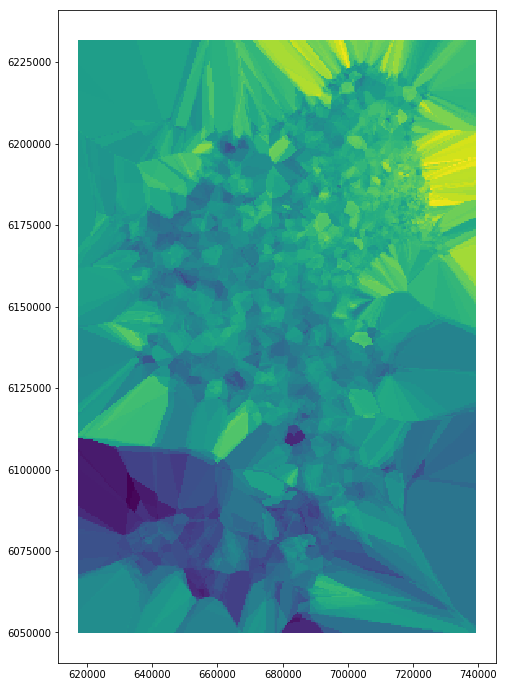

In [17]:
# plot

f, ax = plt.subplots(1, figsize=(12, 12))
ax = square_gdf.plot(column='p_2012',ax=ax)
plt.show()

We have suceeded in creating a pixelated plot of the expected sqm. price in 2012